## Ex-03

### Task-01

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.datasets import make_moons, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [2]:
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.input1 = int(np.round(self.input_size/2))
        self.input2 = self.input_size-self.input1
        self.encoder = nn.Sequential(
            nn.Linear(self.input1, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 2 * self.input2)
            )

    def forward(self, x, rev=False):
        x1, x2 = x[...,:self.input1], x[..., self.input1:]
        param = self.encoder(x1)
        scale, translation = param[..., :self.input2], param[..., self.input2:]
        scale = torch.tanh(scale)
        log_jacob_det = torch.sum(scale, -1)

        if rev:
            scale = torch.exp(-scale)
            x2 = scale*(x2-translation)
            return torch.cat([x1,x2], -1)
        else:
            scale = torch.exp(scale)
            x2 = scale*x2 + translation
            return torch.concat([x1,x2], -1), log_jacob_det

In [3]:
def gram_schmidt(matrix):
    n, _ = matrix.shape
    orthogonal_matrix = torch.zeros_like(matrix)

    for i in range(n):
        vector = matrix[i]
        for j in range(i):
            proj = torch.dot(vector, orthogonal_matrix[j]) * orthogonal_matrix[j]
            vector = vector - proj
        orthogonal_matrix[i] = vector / torch.norm(vector)
    
    return orthogonal_matrix

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        
        self.coupling_blocks = nn.ModuleList()
        for _ in range(blocks):
            self.coupling_blocks.append(CouplingLayer(input_size, hidden_size))
        
        random_matrices = [torch.randn(input_size, input_size) for _ in range(blocks - 1)]
        self.orthogonal_matrices = [gram_schmidt(matrix) for matrix in random_matrices]

    def forward(self, x, rev=False):
        if rev:
            for i in range(self.blocks - 1, 0, -1):
                x = self.coupling_blocks[i](x, rev=True)
                x = torch.matmul(x, self.orthogonal_matrices[i - 1].T)
            x = self.coupling_blocks[0](x, rev=True)
            return x
        else:
            log_jacob_det = torch.zeros((x.shape[0]), device=x.device)
            for i in range(self.blocks - 1):
                x, x_log_jacob_det = self.coupling_blocks[i](x)
                log_jacob_det += x_log_jacob_det
                x = torch.matmul(x, self.orthogonal_matrices[i])
            x, x_log_jacob_det = self.coupling_blocks[-1](x)
            log_jacob_det += x_log_jacob_det
            return x, log_jacob_det
    
    def sample(self, n_samples):
        z = torch.normal(mean=torch.zeros((n_samples, self.input_size)), std=torch.ones((n_samples,self.input_size)))
        return self.forward(z, rev=True)

In [4]:
# Define the training function
def train_inn(model, data_loader, optimizer, epochs):
    for _ in range(epochs):
        for x, _ in data_loader:
            optimizer.zero_grad()

            x = x.view(x.size(0), -1)
            z, log_jacob_det = model(x)
            loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - log_jacob_det)
            
            loss.backward()
            optimizer.step()

        # print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


In [5]:
def generate_data(n_samples=1000, noise=0.1):
    data, _ = make_moons(n_samples=n_samples, shuffle=True, noise=noise)

    data = StandardScaler().fit_transform(data)
    
    data = torch.tensor(data, dtype=torch.float32)
    return data

def generate_data(n_samples=1000, noise=0.1, random_state=1): # ensure reproducibility for testing
    data, _ = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=random_state)

    data = StandardScaler().fit_transform(data)
    
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [6]:
def evaluate_model(model, test_data):
    # set model in evaluation mode
    model.eval()

    total_loss = 0
    with torch.no_grad(): #ensure model's weights does not change
        
        z, log_jacob_det = model(test_data)
        loss = torch.mean(0.5 * torch.sum(z**2, dim=1) - log_jacob_det)
        
        total_loss+=loss.item()
    return total_loss/len(test_data)

In [7]:
def plot_hyperparameter_combinations(data, n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list):

    hyperparam_comb = list(itertools.product(hidden_size_list, blocks_list, epochs_list))
    len_comb = len(hyperparam_comb)
    
    # subplot grid size
    n_cols = 4
    n_rows = (len_comb + n_cols - 1) // n_cols
    
    # Create the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()  # Flatten axes for easy indexing
    
    for i, (hidden_size, blocks, epochs) in enumerate(hyperparam_comb):
        ax = axes[i]

        # Initialize the RealNVP model
        model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        dataset = TensorDataset(data, torch.zeros(data.size(0)))
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        train_inn(model, data_loader, optimizer, epochs=epochs)

        # Generate synthetic samples
        samples = model.sample(n_samples).detach().numpy()

        # Scatter plot: generated vs original
        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Original')
        ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated')
        ax.set_title(f'Epochs: {epochs}, Hidden_size: {hidden_size}, Blocks: {blocks}')
        ax.legend()

    # Remove unused subplots if combinations < total subplots
    for i in range(len(hyperparam_comb), len(axes)):
        fig.delaxes(axes[i])


    plt.tight_layout()
    plt.show()

In [8]:
def evaluate_hyperparameters(n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list):

    results = []

    train_data = generate_data(n_samples=n_samples, noise=0.1, random_state=1)
    test_data = generate_data(n_samples=n_samples, noise=0.1, random_state=1)

    train_dataset = TensorDataset(train_data, torch.zeros(train_data.size(0)))
    data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    for hidden_size in hidden_size_list:
        for blocks in blocks_list:
            
            model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            for epochs in epochs_list:
                train_inn(model, data_loader, optimizer, epochs)
                test_loss = evaluate_model(model, test_data)
                            

                results.append({
                    'hidden_size': hidden_size,
                    'blocks': blocks,
                    'epochs': epochs,
                    'test_loss': test_loss
                })
                print(f'hidden_size={hidden_size}, blocks={blocks}, epochs={epochs} -> test_loss: {test_loss:3f}')

    # plotting scatter plots
    plot_hyperparameter_combinations(train_data, n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list)

    # plotting loss
    param_keys = ['hidden_size', 'blocks', 'epochs']
    fig, axes = plt.subplots(1, len(param_keys), figsize=(len(param_keys)*4,3))
    
    for i, key in enumerate(param_keys):
        param_vals = sorted(set([result[key] for result in results]))
        mean_losses = []
        for val in param_vals:
            losses = [result['test_loss'] for result in results if result[key]==val]
            mean_losses.append(np.mean(losses))

        axes[i].plot(param_vals, mean_losses, marker='o')
        axes[i].set_title(f'Reconstruction Error for {key}')
        axes[i].set_xlabel(key)
        axes[i].set_ylabel('Reconstruction error')
        axes[i].grid()
    
    plt.tight_layout()
    plt.show()


                         
    return results

hidden_size=32, blocks=6, epochs=10 -> test_loss: 0.000400
hidden_size=32, blocks=6, epochs=100 -> test_loss: 0.000205
hidden_size=32, blocks=8, epochs=10 -> test_loss: 0.000431
hidden_size=32, blocks=8, epochs=100 -> test_loss: 0.000146
hidden_size=32, blocks=10, epochs=10 -> test_loss: 0.000327
hidden_size=32, blocks=10, epochs=100 -> test_loss: 0.000056
hidden_size=64, blocks=6, epochs=10 -> test_loss: 0.000450
hidden_size=64, blocks=6, epochs=100 -> test_loss: 0.000190
hidden_size=64, blocks=8, epochs=10 -> test_loss: 0.000267
hidden_size=64, blocks=8, epochs=100 -> test_loss: 0.000112
hidden_size=64, blocks=10, epochs=10 -> test_loss: 0.000269
hidden_size=64, blocks=10, epochs=100 -> test_loss: 0.000018
hidden_size=128, blocks=6, epochs=10 -> test_loss: 0.000365
hidden_size=128, blocks=6, epochs=100 -> test_loss: 0.000090
hidden_size=128, blocks=8, epochs=10 -> test_loss: 0.000459
hidden_size=128, blocks=8, epochs=100 -> test_loss: 0.000062
hidden_size=128, blocks=10, epochs=10 ->

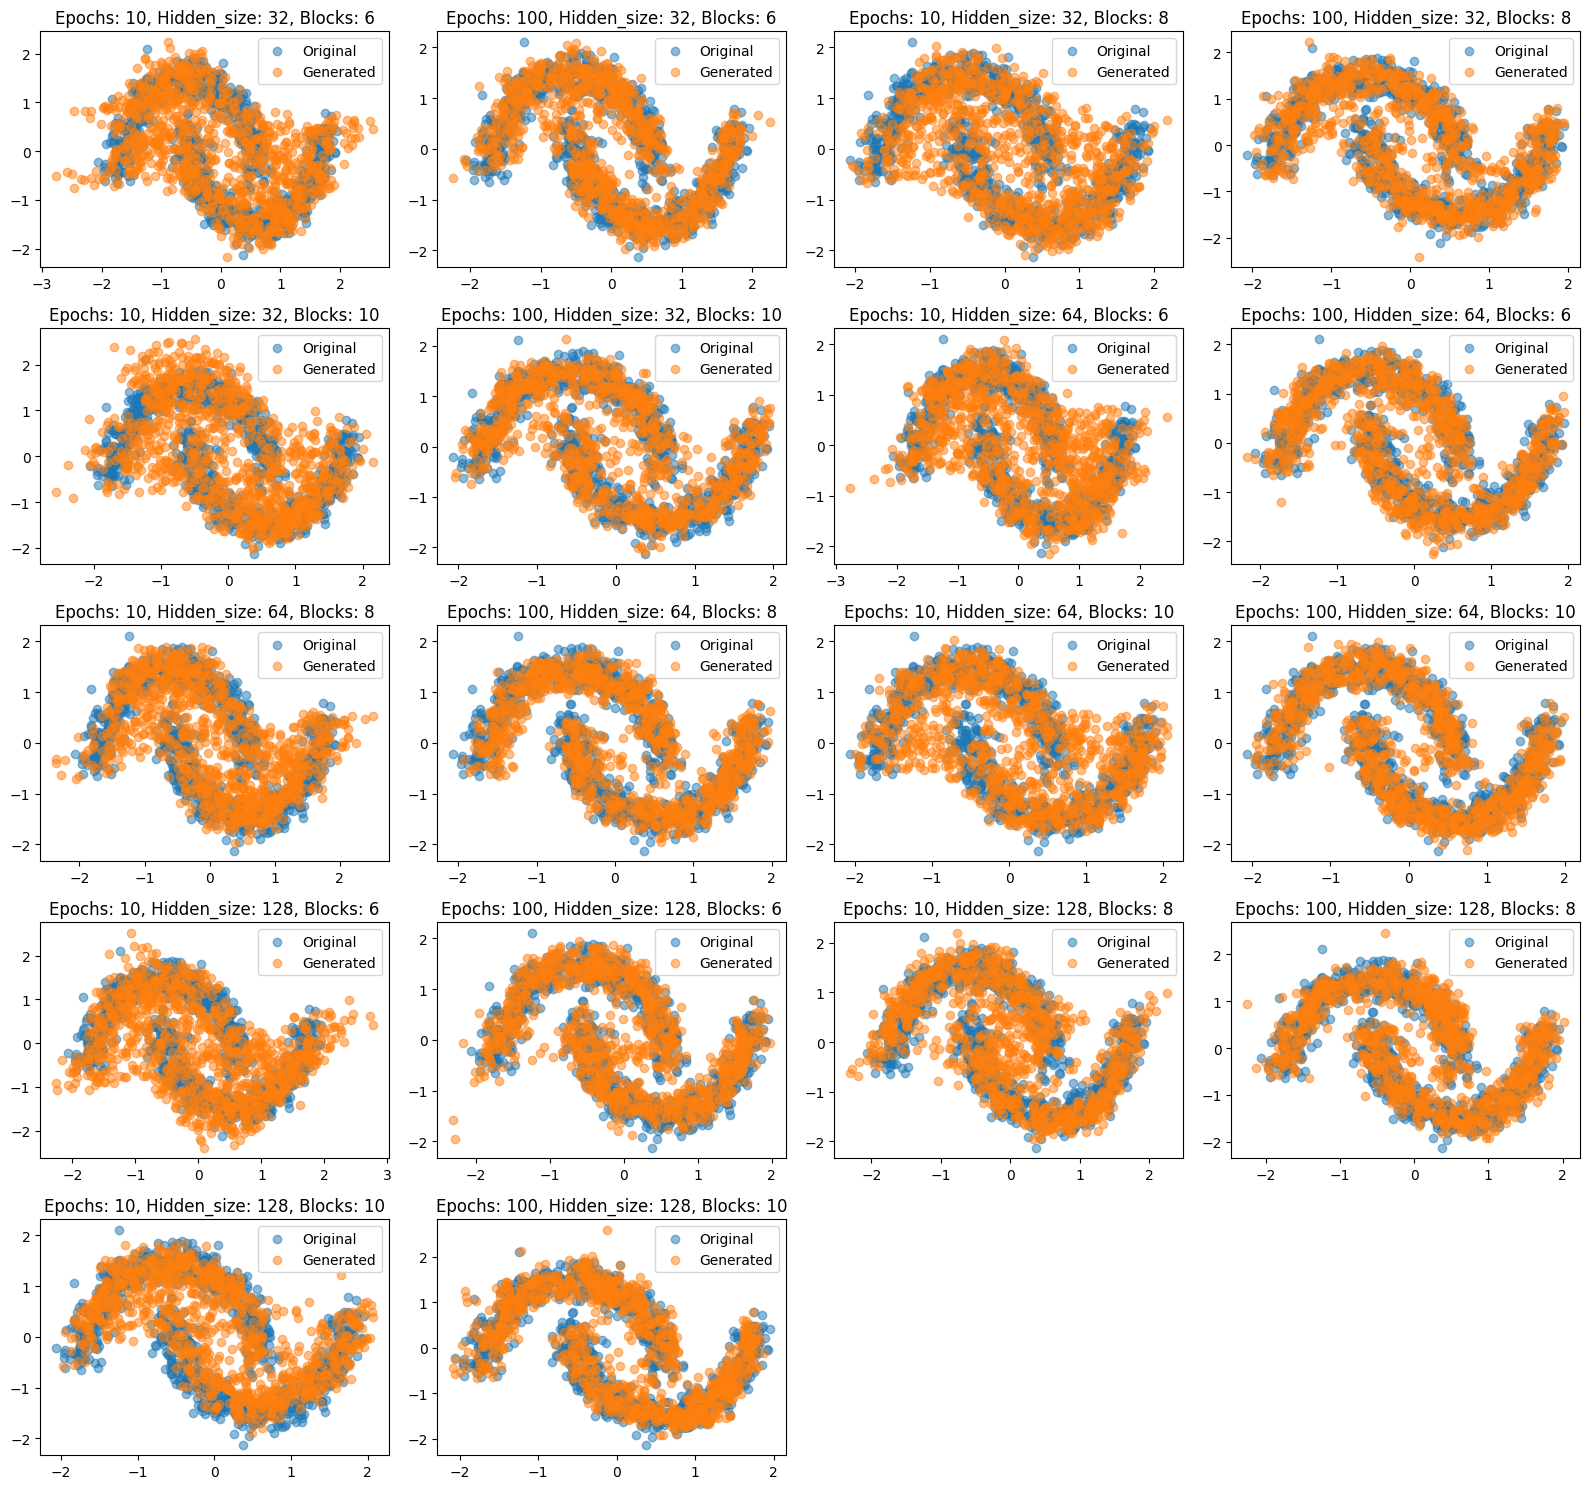

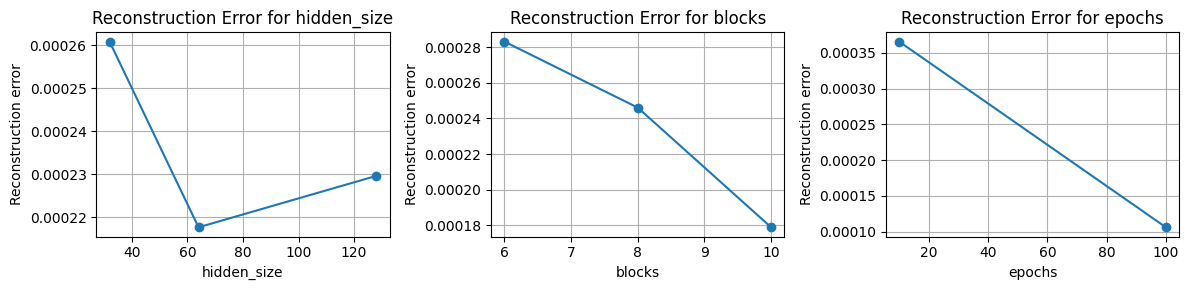

In [9]:
# parameters
n_samples = 1000
noise = 0.1
input_size = 2
lr = 0.001
hidden_size_list = [32, 64, 128]
blocks_list = [6, 8, 10]
epochs_list = [10, 100]

results = evaluate_hyperparameters(n_samples, input_size, lr, hidden_size_list, blocks_list, epochs_list)


MMD

In [10]:
def inverse_multi_quadratic_kernel(x, y, bandwidth=1.0):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.detach().numpy()
        
    pairwise_dists = cdist(x, y, metric='sqeuclidean')
    return bandwidth / (bandwidth + pairwise_dists)

def compute_mmd(test_set, generated_set, bandwidth=1.0):
    xx = inverse_multi_quadratic_kernel(test_set, test_set, bandwidth)
    yy = inverse_multi_quadratic_kernel(generated_set, generated_set, bandwidth)
    xy = inverse_multi_quadratic_kernel(test_set, generated_set, bandwidth)
    
    mmd = np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)
    return mmd

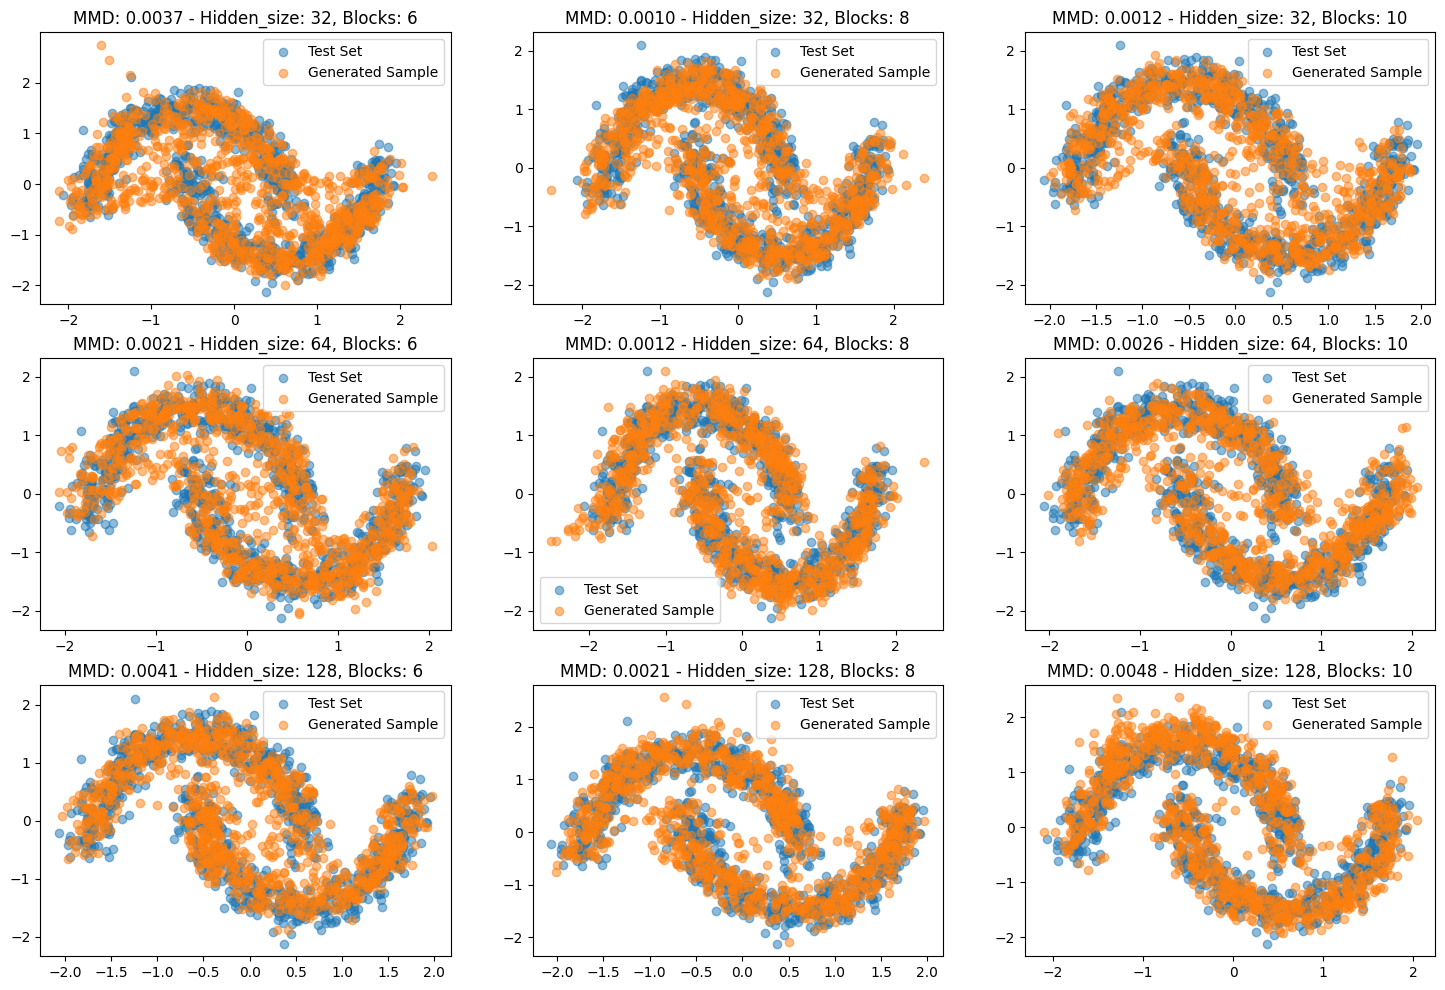

In [11]:
bandwidth = 1.0
n_samples = 1000
epochs = 100
hidden_size_list = [32, 64, 128]
blocks_list = [6, 8, 10]

test_dataset = generate_data(n_samples, noise, random_state=1)

fig, axes = plt.subplots(len(hidden_size_list), len(blocks_list), figsize=(18, 12))
for i, hidden_size in enumerate(hidden_size_list):
    for j, blocks in enumerate(blocks_list):
        ax = axes[i,j]
        model = RealNVP(input_size, hidden_size, blocks)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        dataset = TensorDataset(test_dataset, torch.zeros(test_dataset.size(0)))
        data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

        train_inn(model, data_loader, optimizer,  epochs)

        # Generate synthetic samples using RealNVP
        generated_samples = model.sample(n_samples).detach().numpy()

        # Compute MMD
        mmd_value = compute_mmd(test_dataset, generated_samples, bandwidth=bandwidth)

        ax.scatter(test_dataset[:, 0], test_dataset[:, 1], alpha=0.5, label='Test Set')
        ax.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated Sample')
        ax.set_title(f'MMD: {mmd_value:.4f} - Hidden_size: {hidden_size}, Blocks: {blocks}')
        ax.legend()
plt.legend()
plt.show()


GMM

In [12]:
def hexa_gmm(n_samples, radius=1, std_dev=0.1):
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]  # 6 points on the hexagon
    centers = np.array([[radius * np.cos(angle), radius * np.sin(angle)] for angle in angles])
    
    # dummy data for initialization
    data = np.vstack([np.random.multivariate_normal(center, np.eye(2) * std_dev**2, size=n_samples // 6) for center in centers])
    
    gmm = GaussianMixture(n_components=6, covariance_type='spherical', random_state=42)
    gmm.fit(data)  # Fit the model to the generated data
    
    samples, _ = gmm.sample(n_samples)
    return samples

In [13]:
def train_gmm_inn(model, n_samples, epochs):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Generate data and convert to tensor
        x_data = hexa_gmm(n_samples)
        x_data = torch.tensor(x_data, dtype=torch.float32)  # Convert to PyTorch tensor
        
        z, log_jacob_det = model(x_data)
        loss = torch.mean(0.5 * torch.sum(z**2, -1) - log_jacob_det)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

Epoch [10/100], Loss: -0.0992
Epoch [20/100], Loss: -0.2831
Epoch [30/100], Loss: -0.2487
Epoch [40/100], Loss: -0.4386
Epoch [50/100], Loss: -0.6284
Epoch [60/100], Loss: -0.7670
Epoch [70/100], Loss: -0.9032
Epoch [80/100], Loss: -1.0218
Epoch [90/100], Loss: -1.0948
Epoch [100/100], Loss: -1.1414


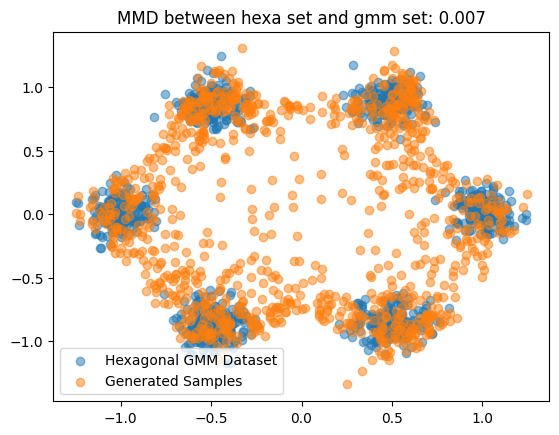

In [14]:
n_samples = 1000
hidden_size = 64
blocks = 10
epochs = 100
radius = 1.0
std_dev = 0.1

hexa_dataset = hexa_gmm(n_samples, radius, std_dev)

gmm_model = RealNVP(input_size, hidden_size=hidden_size, blocks=blocks)
train_gmm_inn(gmm_model, n_samples, epochs)
gmm_dataset = gmm_model.sample(n_samples).detach().numpy()

mmd_value = compute_mmd(hexa_dataset, gmm_dataset, bandwidth=1.0)

plt.scatter(hexa_dataset[:, 0], hexa_dataset[:, 1], alpha=0.5, label='Hexagonal GMM Dataset')
plt.scatter(gmm_dataset[:,0], gmm_dataset[:,1], alpha=0.5, label='Generated Samples')
plt.title(f'MMD between hexa set and gmm set: {mmd_value:.3f}')
plt.legend()
plt.show()

---

### Task 3.1

In [15]:
def train_digit_inn(model, optimizer, train_data, epochs, batch_size):

    data_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in data_loader:
            optimizer.zero_grad()
            
            batch = batch[0]

            z, log_jacob_det = model(batch)

            loss = -torch.mean(-0.5 * torch.sum(z**2 + torch.log(torch.tensor(2 * torch.pi, device=z.device) + 1e-8), dim=1) + log_jacob_det)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # average loss for this epoch
        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.3f}")

    return losses

2-dim PCA to observe of 64 dimensional data in 2-D space

Epoch 1/500, Loss: 39.151
Epoch 21/500, Loss: -70.137
Epoch 41/500, Loss: -82.592
Epoch 61/500, Loss: -90.521
Epoch 81/500, Loss: -96.700
Epoch 101/500, Loss: -100.368
Epoch 121/500, Loss: -103.768
Epoch 141/500, Loss: -108.936
Epoch 161/500, Loss: -111.476
Epoch 181/500, Loss: -112.070
Epoch 201/500, Loss: -116.046
Epoch 221/500, Loss: -114.416
Epoch 241/500, Loss: -117.504
Epoch 261/500, Loss: -120.808
Epoch 281/500, Loss: -123.576
Epoch 301/500, Loss: -123.653
Epoch 321/500, Loss: -123.196
Epoch 341/500, Loss: -128.731
Epoch 361/500, Loss: -130.221
Epoch 381/500, Loss: -129.592
Epoch 401/500, Loss: -129.394
Epoch 421/500, Loss: -125.769
Epoch 441/500, Loss: -131.899
Epoch 461/500, Loss: -132.488
Epoch 481/500, Loss: -131.820


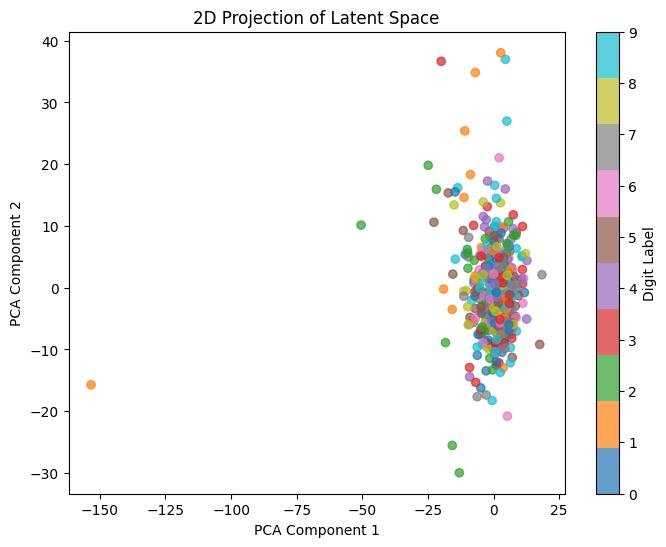

In [16]:
# loading digits data
digits = load_digits()
x = digits.data / 16.0  # normalize between [0, 1]
y = digits.target

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=1)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)


# training parameters
input_size = x_train.size(1)
hidden_size = 128
blocks = 10
epochs = 500
batch_size = 128
lr = 0.001

model = RealNVP(input_size, hidden_size, blocks)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_digit_inn(model, optimizer, x_train, epochs, batch_size)

z, _ = model(x_test)
z = z.detach().numpy()

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar(label="Digit Label")
plt.title("2D Projection of Latent Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


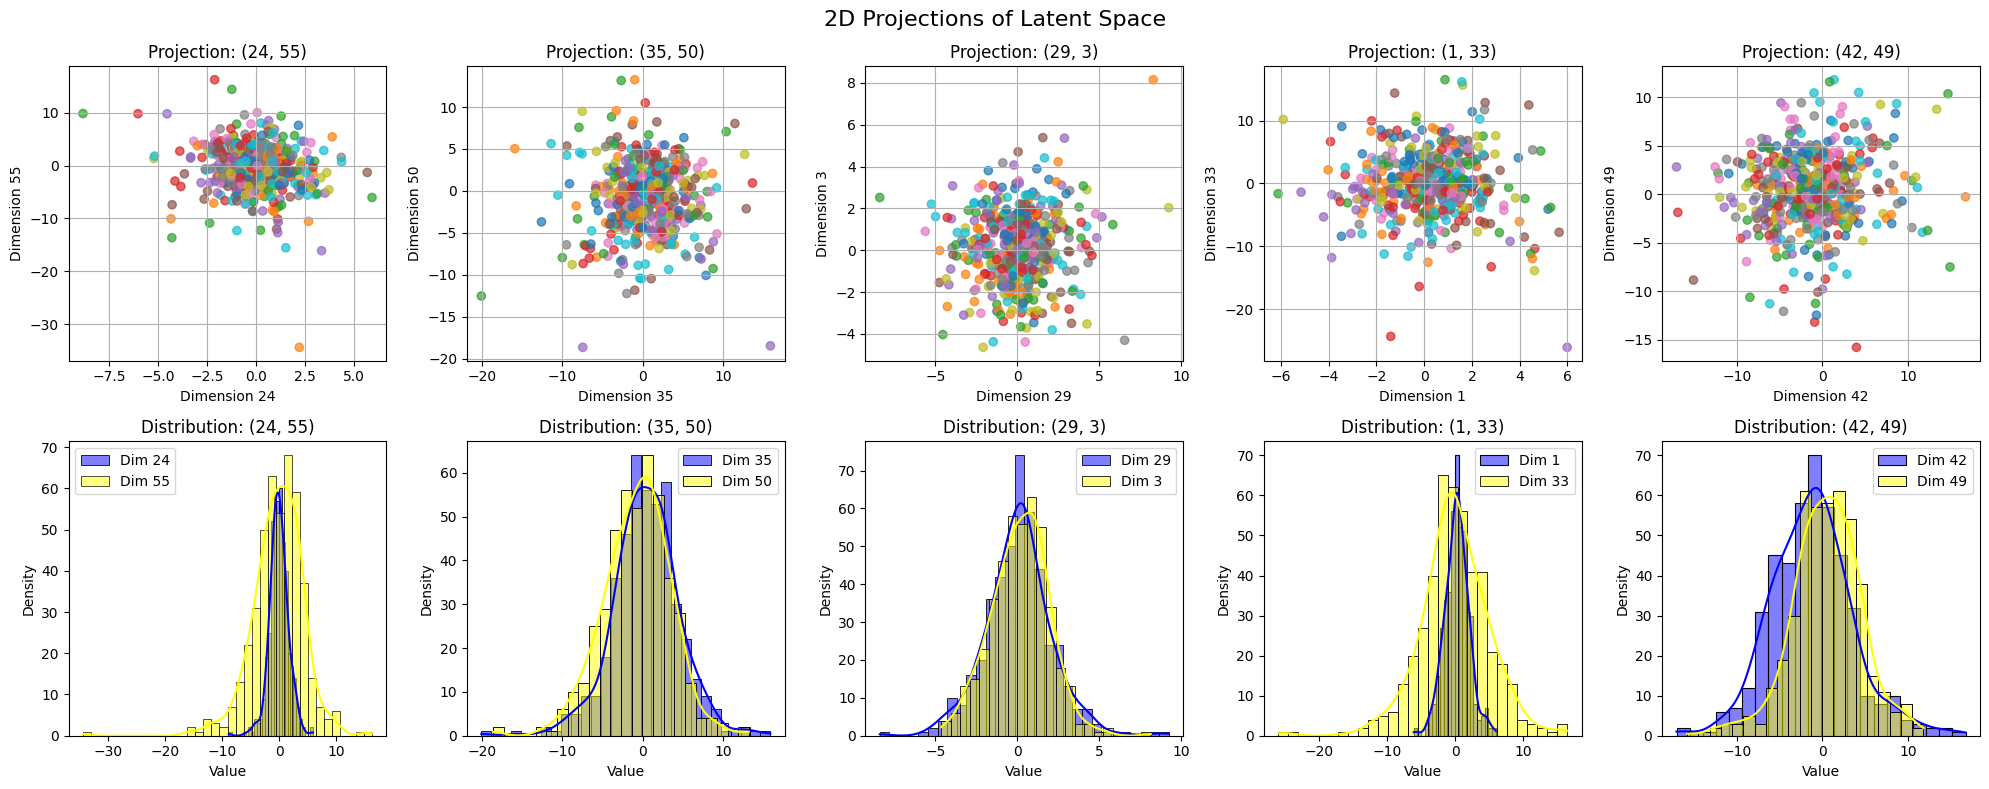

In [17]:
def projections_2d(latent_codes, dims, title="2D Projections of Latent Space"):
    num_plots = len(dims)
    fig, axes = plt.subplots(2, num_plots, figsize=(4*num_plots, 8))
    
    if num_plots == 1:
        axes = [[axes[0]], [axes[1]]]  # Ensure axes is iterable for a single subplot
    
    for i, (dim1, dim2) in enumerate(dims):
        ax = axes[0][i]
        ax.scatter(latent_codes[:, dim1], latent_codes[:, dim2], c=y_test, cmap='tab10', alpha=0.7)
        ax.set_xlabel(f"Dimension {dim1}")
        ax.set_ylabel(f"Dimension {dim2}")
        ax.set_title(f"Projection: ({dim1}, {dim2})")
        ax.grid(True)

        # Plot histogram for first and second dimensions in the pair
        ax_hist = axes[1][i]
        sns.histplot(latent_codes[:, dim1], kde=True, ax=ax_hist, label=f"Dim {dim1}", color="blue", alpha=0.5)
        sns.histplot(latent_codes[:, dim2], kde=True, ax=ax_hist, label=f"Dim {dim2}", color="yellow", alpha=0.5)
        ax_hist.set_title(f"Distribution: ({dim1}, {dim2})")
        ax_hist.set_xlabel("Value")
        ax_hist.set_ylabel("Density")
        ax_hist.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# dimension pairs to observe
dims = [(24, 55), (35, 50), (29, 3), (1, 33), (42, 49)]
projections_2d(z, dims)

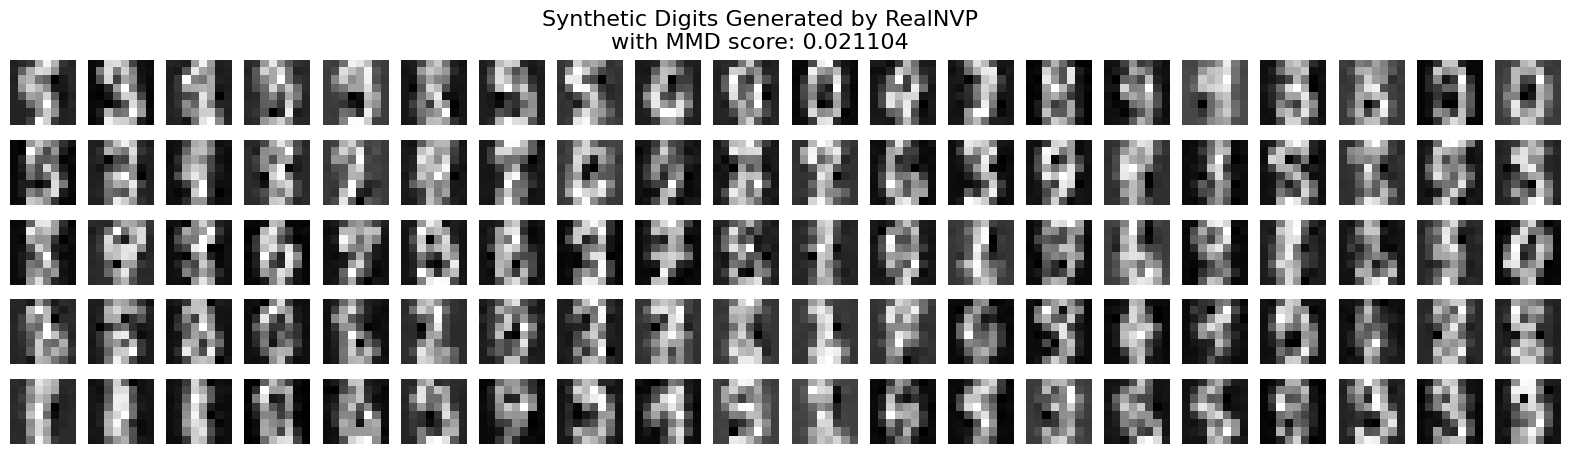

In [18]:
# Generate synthetic data
n_samples = 100
synthetic_digits = model.sample(n_samples).detach().numpy()

fig, axes = plt.subplots(5, 20, figsize=(20, 5))
for i, ax in enumerate(axes.ravel()):
    if i < n_samples:
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle(f"Synthetic Digits Generated by RealNVP\nwith MMD score: {compute_mmd(x_test, synthetic_digits, bandwidth=bandwidth):4f}", fontsize=16)
plt.show()


### Task 3.2

In [19]:
class bottleneck_RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, bottleneck):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        self.bottleneck = bottleneck
        self.coupling_blocks = nn.ModuleList()
        for _ in range(blocks):
            self.coupling_blocks.append(CouplingLayer(input_size, hidden_size))
        
        random_matrices = [torch.randn(input_size, input_size) for _ in range(blocks - 1)]
        self.orthogonal_matrices = [gram_schmidt(matrix) for matrix in random_matrices]

    def forward(self, x, rev=False):
        if rev:
            for i in range(self.blocks - 1, 0, -1):
                x = self.coupling_blocks[i](x, rev=True)
                x = torch.matmul(x, self.orthogonal_matrices[i - 1].T)
            x = self.coupling_blocks[0](x, rev=True)
            return x
        else:
            log_jacob_det = torch.zeros((x.shape[0]), device=x.device)
            for i in range(self.blocks - 1):
                x, x_log_jacob_det = self.coupling_blocks[i](x)
                log_jacob_det += x_log_jacob_det
                x = torch.matmul(x, self.orthogonal_matrices[i])
            x, x_log_jacob_det = self.coupling_blocks[-1](x)
            log_jacob_det += x_log_jacob_det
            return x, log_jacob_det
    
    def decode_with_bottleneck(self, z):
        z_bottleneck = torch.zeros_like(z)
        z_bottleneck[:, :self.bottleneck] = z[:, :self.bottleneck]
        return self.forward(z_bottleneck, rev=True)    

    def sample(self, n_samples, variant=None):
        z = torch.normal(mean=torch.zeros((n_samples, self.input_size)), std=torch.ones((n_samples, self.input_size)))

        if variant == 'important': #sampling first k dimensions, set rest to zero
            z[:, self.bottleneck:] = 0
            return self.decode_with_bottleneck(z)
        
        elif variant == 'unimportant': # keeping first k dimensions fixed, sample the rest
            z[:, :self.bottleneck] = 0
            return self.decode_with_bottleneck(z)
        
        else: return self.decode_with_bottleneck(z)

In [20]:
def train_digit_inn(model, optimizer, train_data, epochs, batch_size, bottleneck): # parameter bottleneck is not used but only passed to ensure method overloading
    data_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in data_loader:
            optimizer.zero_grad()
            
            batch = batch[0]

            z, log_jacob_det = model(batch)
            loss = -torch.mean(-0.5 * torch.sum(z**2 + torch.log(torch.tensor(2 * torch.pi, device=z.device) + 1e-8), dim=1) + log_jacob_det)
            
            reconstructed = model.decode_with_bottleneck(z)
            reconstruction_loss = torch.mean((batch - reconstructed)**2)

            total_loss = loss + reconstruction_loss

            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.3f}")

    return losses

Epoch 1/10, Loss: 40.840


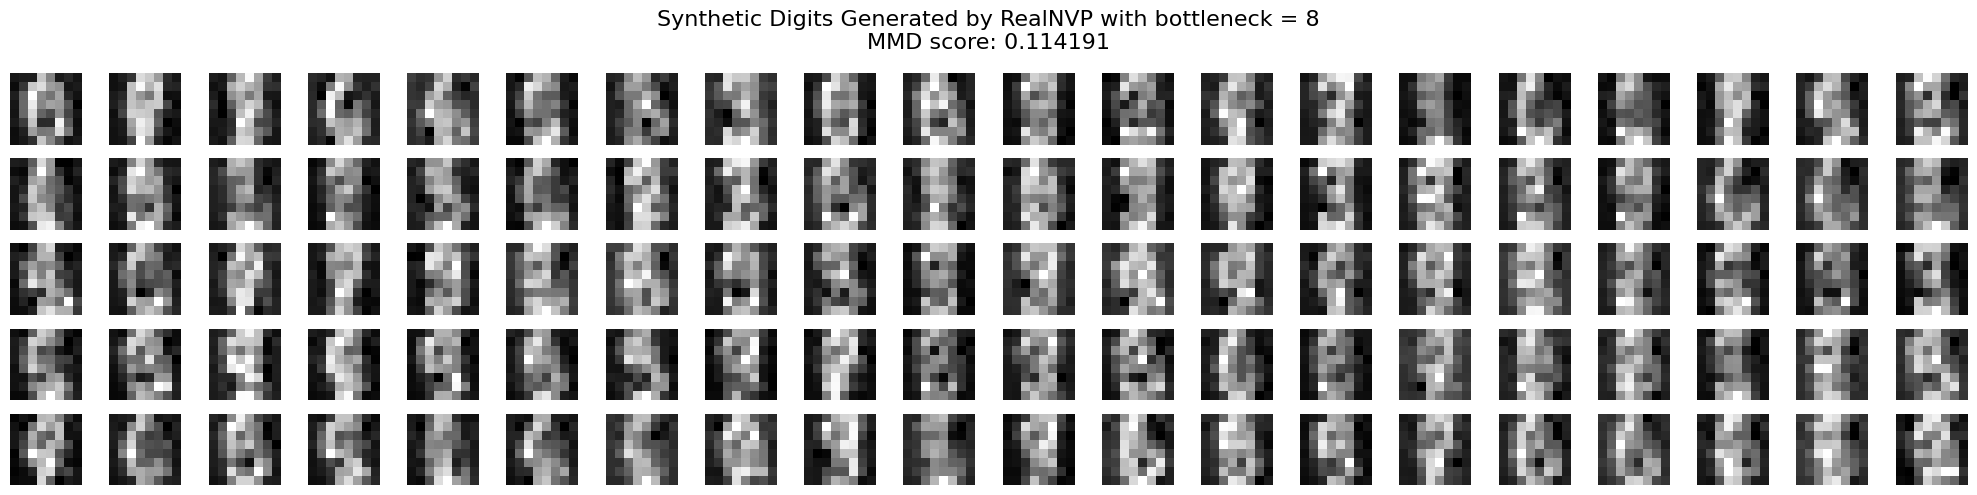

In [21]:
k = 8
epochs = 10

model = bottleneck_RealNVP(input_size, hidden_size, blocks, bottleneck=k)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_digit_inn(model, optimizer, x_train, epochs, batch_size, bottleneck=k)


synthetic_digits = model.sample(n_samples).detach().numpy()

fig, axes = plt.subplots(5, 20, figsize=(20, 5))
for i, ax in enumerate(axes.ravel()):
    if i < n_samples:
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle(f"Synthetic Digits Generated by RealNVP with bottleneck = {k}\nMMD score: {compute_mmd(x_test, synthetic_digits, bandwidth=bandwidth):4f}", fontsize=16)
plt.tight_layout()
plt.show()


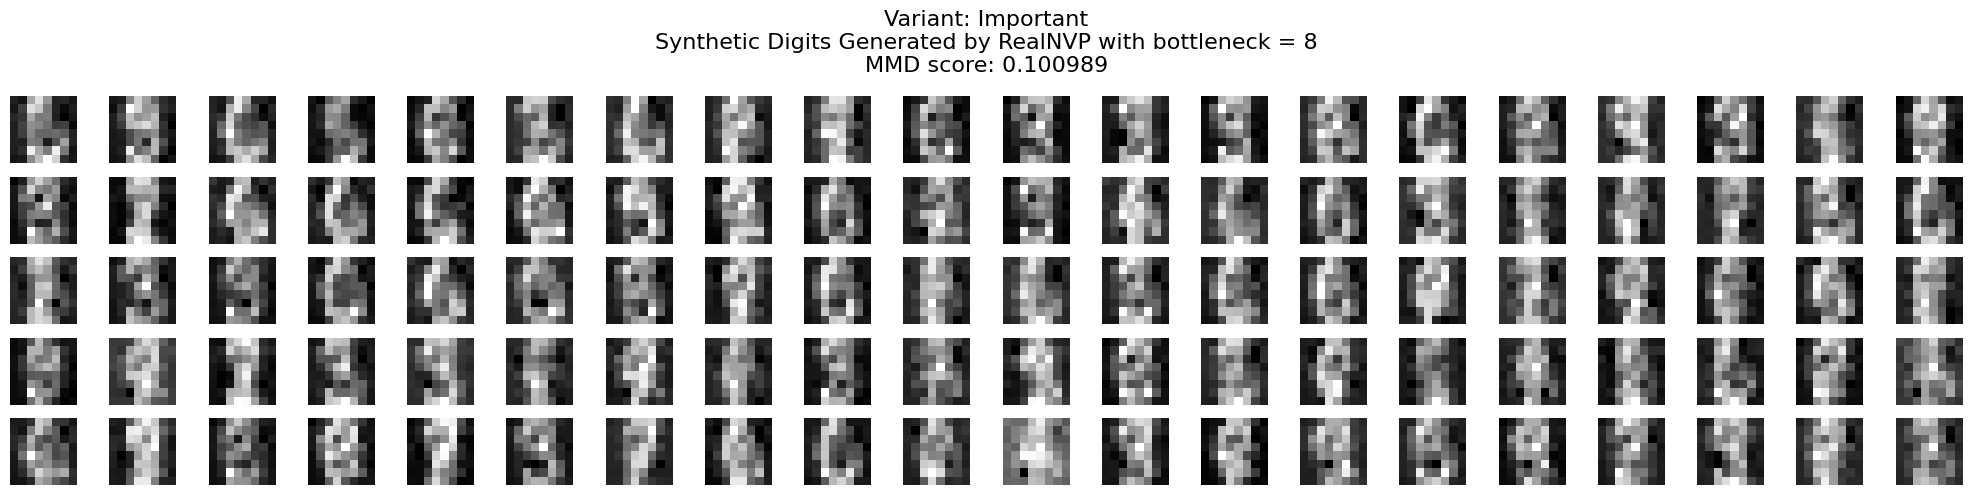

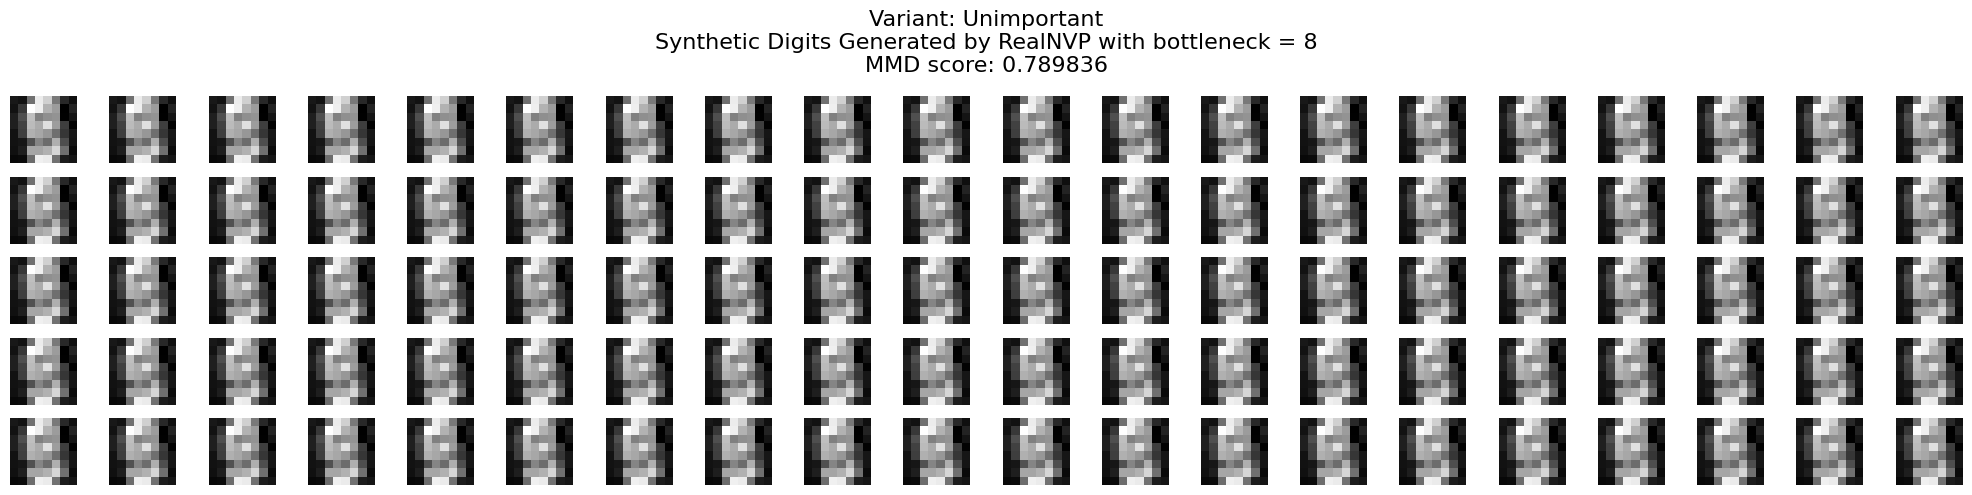

In [22]:
# variant 1: important
synthetic_digits = model.sample(n_samples, variant='important').detach().numpy()

fig, axes = plt.subplots(5, 20, figsize=(20, 5))
for i, ax in enumerate(axes.ravel()):
    if i < n_samples:
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle(f"Variant: Important\nSynthetic Digits Generated by RealNVP with bottleneck = {k}\nMMD score: {compute_mmd(x_test, synthetic_digits, bandwidth=bandwidth):4f}", fontsize=16)
plt.tight_layout()
plt.show()


# variant 2: unimportant
synthetic_digits = model.sample(n_samples, variant='unimportant').detach().numpy()

fig, axes = plt.subplots(5, 20, figsize=(20, 5))
for i, ax in enumerate(axes.ravel()):
    if i < n_samples:
        ax.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle(f"Variant: Unimportant\nSynthetic Digits Generated by RealNVP with bottleneck = {k}\nMMD score: {compute_mmd(x_test, synthetic_digits, bandwidth=bandwidth):4f}", fontsize=16)
plt.tight_layout()
plt.show()

### Task 3.2

In [23]:
from torchvision import datasets, transforms
from PIL import Image


# Define a functor to downsample images
class DownsampleTransform:
    def __init__(self, target_shape, algorithm=Image.Resampling.LANCZOS):
        self.width, self.height = target_shape
        self.algorithm = algorithm

    def __call__(self, img):
        img = img.resize((self.width + 2, self.height + 2), self.algorithm)
        img = img.crop((1, 1, self.width + 1, self.height + 1))
        return img
    
# Preprocess the MNIST dataset (downsample to 8x8)
transform = transforms.Compose([
    DownsampleTransform(target_shape=(8, 8)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# download MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

data_loader = DataLoader(mnist_dataset, batch_size=100, shuffle=True)

# visualize the first batch of downsampled MNIST images
def show_first_batch(data_loader):
    for batch in data_loader:
        x, _ = batch
        fig = plt.figure(figsize=(10, 10))
        for i, img in enumerate(x[:100]):
            ax = fig.add_subplot(10, 10, i + 1)
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.show()
        break

using the model achitecture of task 3.1 (without bottleneck)

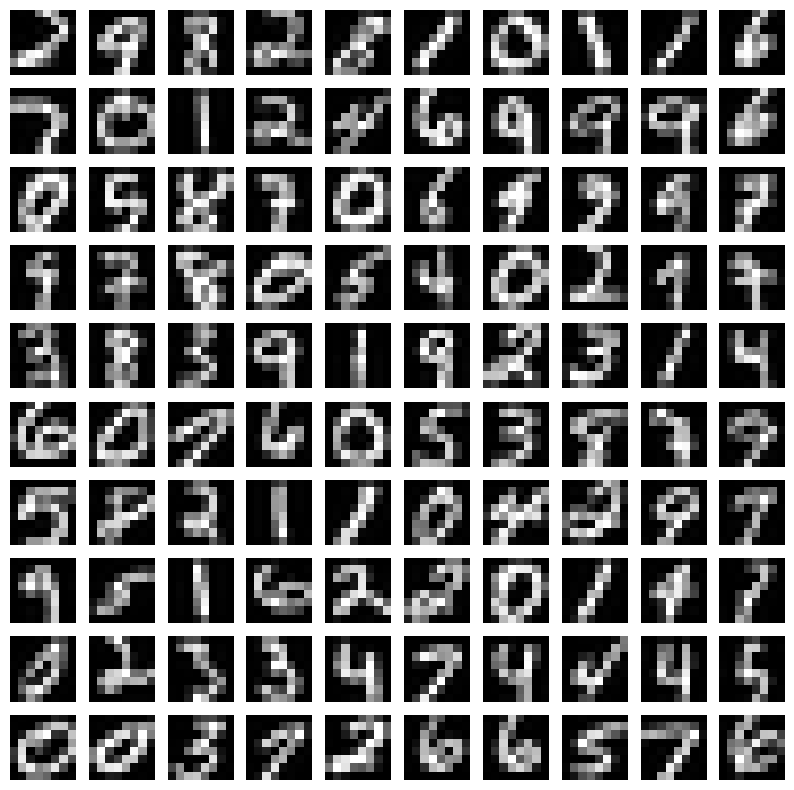

Epoch 1/10, Loss: -53.6900
Epoch 2/10, Loss: -80.1220
Epoch 3/10, Loss: -88.6195
Epoch 4/10, Loss: -93.4460
Epoch 5/10, Loss: -97.0125
Epoch 6/10, Loss: -99.9751
Epoch 7/10, Loss: -102.0851
Epoch 8/10, Loss: -103.9074
Epoch 9/10, Loss: -105.5287
Epoch 10/10, Loss: -106.9534


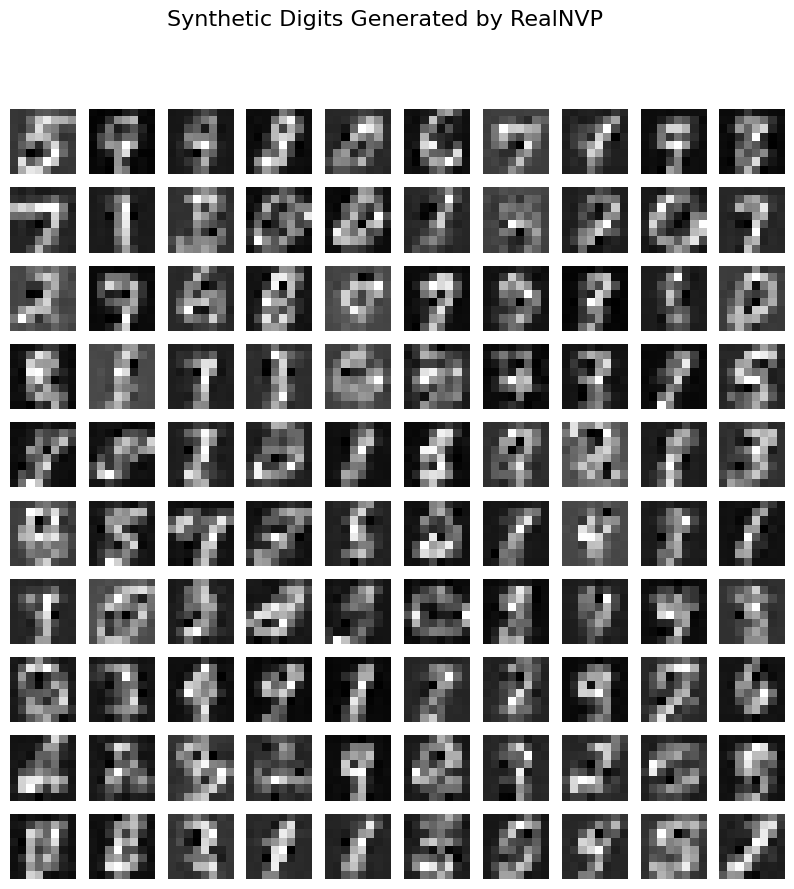

In [25]:
# Training function for RealNVP
def train_mnist_inn(model, optimizer, data_loader, epochs):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in data_loader:
            optimizer.zero_grad()

            x, _ = batch
            x = x.view(x.size(0), -1)  # Flattening images

            z, log_jacob_det = model(x)

            loss = -torch.mean(-0.5 * torch.sum(z ** 2 + torch.log(torch.tensor(2 * np.pi)), dim=1) + log_jacob_det)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # average loss for this epoch
        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data_loader):.4f}")
    return losses



# first batch of the dataset
show_first_batch(data_loader)

# parameters
input_size = 8 * 8
hidden_size = 128
blocks = 10
epochs = 10
n_samples=100

model = RealNVP(input_size=input_size, hidden_size=hidden_size, blocks=blocks)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_mnist_inn(model, optimizer, data_loader, epochs)

# Generate and visualize samples
synthetic_digits = model.sample(n_samples).detach().numpy()
fig = plt.figure(figsize=(10, 10))
for i, img in enumerate(synthetic_digits):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(img.reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle(f"Synthetic Digits Generated by RealNVP", fontsize=16)
plt.show()
